In [125]:
import torch
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from PIL import Image
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import time

In [126]:
path = "/home/kevin/deep_learning/iwildcam/"

# Metadata loading and exploration

In [127]:
md = pd.read_csv(path + "train.csv")
md.head()

,category_id,date_captured,file_name,frame_num,id,location,rights_holder,seq_id,seq_num_frames,width,height
0,19,2011-05-13 23:43:18,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,1,5998cfa4-23d2-11e8-a6a3-ec086b02610b,33,Justin Brown,6f084ccc-5567-11e8-bc84-dca9047ef277,3,1024,747
1,19,2012-03-17 03:48:44,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,2,588a679f-23d2-11e8-a6a3-ec086b02610b,115,Justin Brown,6f12067d-5567-11e8-b3c0-dca9047ef277,3,1024,747
2,0,2014-05-11 11:56:46,59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg,1,59279ce3-23d2-11e8-a6a3-ec086b02610b,96,Erin Boydston,6faa92d1-5567-11e8-b1ae-dca9047ef277,1,1024,747
3,0,2013-10-06 02:00:00,5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg,1,5a2af4ab-23d2-11e8-a6a3-ec086b02610b,57,Erin Boydston,6f7d4702-5567-11e8-9e03-dca9047ef277,1,1024,747
4,0,2011-07-12 13:11:16,599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg,3,599fbd89-23d2-11e8-a6a3-ec086b02610b,46,Justin Brown,6f1728a1-5567-11e8-9be7-dca9047ef277,3,1024,747


In [36]:
cats = pd.read_csv(path + "categories.txt")
cats.head()

,name,id
0,empty,0
1,deer,1
2,moose,2
3,squirrel,3
4,rodent,4


[Text(0, 0, 'empty'),
 Text(0, 0, 'deer'),
 Text(0, 0, 'squirrel'),
 Text(0, 0, 'rodent'),
 Text(0, 0, 'rabbit'),
 Text(0, 0, 'fox'),
 Text(0, 0, 'coyote'),
 Text(0, 0, 'raccoon'),
 Text(0, 0, 'skunk'),
 Text(0, 0, 'bobcat'),
 Text(0, 0, 'cat'),
 Text(0, 0, 'dog'),
 Text(0, 0, 'opossum'),
 Text(0, 0, 'mountain_lion')]

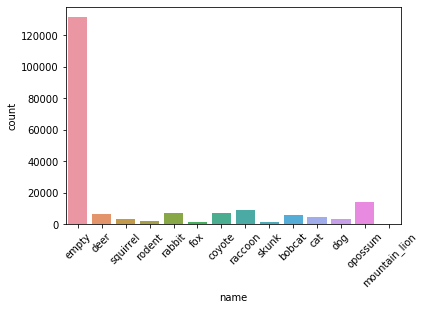

In [37]:
# Plot category frequencies
cat_freq = pd.DataFrame(md.category_id.value_counts())
cat_freq['id'] = list(cat_freq.index)
cat_freq.columns = ['count', 'id']
cat_freq = cat_freq.sort_values(by='id')
cat_freq['name'] = cats['name']
ax = sns.barplot(data=cat_freq, x='name', y='count')
ax.set_xticklabels(rotation=45, labels = ax.get_xticklabels())

# Images
Look at some of them images.

      name  id
11  coyote  11


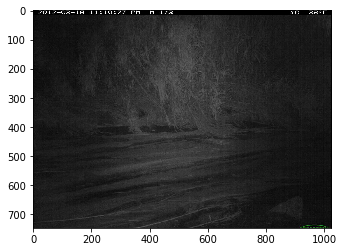

In [79]:
# Get some image that's not empty
keep = list(md['category_id'] != 0)
md_sub = md.loc[keep]
file_names = list(md_sub['file_name'])

idx = 10291
img = file_names[idx]

# load and show image
im = Image.open(os.path.join(path,"train_images",img))
plt.imshow(im)

# check what's in the image
ids = list(md_sub['category_id'])
i = ids[idx]
animal = str(cats.loc[cats['id'] == i])
print(animal)

# Training Dataset Object

In [98]:
labels_path = os.path.join(path, "train.csv")
labels = pd.read_csv(labels_path)
labels.head()

,category_id,date_captured,file_name,frame_num,id,location,rights_holder,seq_id,seq_num_frames,width,height
0,19,2011-05-13 23:43:18,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,1,5998cfa4-23d2-11e8-a6a3-ec086b02610b,33,Justin Brown,6f084ccc-5567-11e8-bc84-dca9047ef277,3,1024,747
1,19,2012-03-17 03:48:44,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,2,588a679f-23d2-11e8-a6a3-ec086b02610b,115,Justin Brown,6f12067d-5567-11e8-b3c0-dca9047ef277,3,1024,747
2,0,2014-05-11 11:56:46,59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg,1,59279ce3-23d2-11e8-a6a3-ec086b02610b,96,Erin Boydston,6faa92d1-5567-11e8-b1ae-dca9047ef277,1,1024,747
3,0,2013-10-06 02:00:00,5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg,1,5a2af4ab-23d2-11e8-a6a3-ec086b02610b,57,Erin Boydston,6f7d4702-5567-11e8-9e03-dca9047ef277,1,1024,747
4,0,2011-07-12 13:11:16,599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg,3,599fbd89-23d2-11e8-a6a3-ec086b02610b,46,Justin Brown,6f1728a1-5567-11e8-9be7-dca9047ef277,3,1024,747


In [99]:
set(labels['category_id'])

{0, 1, 3, 4, 8, 10, 11, 13, 14, 16, 17, 18, 19, 22}

In [123]:
class WildcamDataset(Dataset):
    """Wildcam Image Dataset"""
    
    def __init__(self, label_file, root_dir, transform=None, n_classes=23):
        self.labels = pd.read_csv(label_file)
        self.root_dir = root_dir
        self.transform = transform
        self.n_classes = n_classes
        
        # Get images
        self.images = np.array(self.labels['file_name'])
        
        # Create one-hot encoded labels
        lab_vec = np.zeros((self.labels.shape[0], self.n_classes))
        for idx in range(lab_vec.shape[0]):
            lab_vec[idx][self.labels['category_id'][idx]] = 1
        self.labels = lab_vec    
        


    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        """ Get an image"""
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        # Load image
        img = self.images[idx]
        image = Image.open(os.path.join(self.root_dir, img))

        # Apply transform
        if self.transform is not None:
            image = self.transform(image)
        
        return {'image': image, 'label': self.labels[idx]}

In [124]:
root_dir = os.path.join(path, "train_images")
label_file = os.path.join(path, "train.csv")

dataset = WildcamDataset(label_file = label_file, root_dir = root_dir)

In [122]:
dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x747 at 0x7FF9265C9490>,
 'label': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0.])}